In [1]:
# https://www.kaggle.com/c/liverpool-ion-switching/overview
import os
import time
import math
import random
from collections import deque

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
# dir_path = '/content/drive/My Drive/Colab Notebooks/liverpool_ion_channels/may_21_2/'

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
# DataLoader and Dataset using torch's functions
# torch.float64 is Double. torch.float32 is Float
class IonDataset(Dataset):
    
    def __init__(self, csv_file, seq_dim=10, for_training=True, train_avg=0, train_std=1):
        self.samples = pd.read_csv(csv_file)
        self.samples['observation_batch'] = self.samples['time'].apply(lambda x: math.trunc((x-.0001)/50))
        self.samples['new_time'] = self.samples['time'].apply(lambda x: (x-.0001)%50+.0001)
        self.seq_dim = seq_dim
        self.for_training = for_training
        self.num_of_observations = self.samples['observation_batch'].max()
        self.categories = self.getcategories()
        
        if for_training:
            self.avg = self.getsignalavg()
            self.std = self.getsignalstd()
        else:
            self.avg = train_avg
            self.std = train_std
        self.samples['normalized_signal'] = (self.samples['signal'] - self.avg) / self.std

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        observation = self.samples.iloc[idx]
        obs_batch = observation['observation_batch']
        
        observation_slice = self.samples[max(idx-self.seq_dim+1, 0):idx+1]
        observation_slice = observation_slice[observation_slice.observation_batch == obs_batch]
        
        
        sample = observation_slice.loc[:, ('normalized_signal')]
        sample = torch.tensor(sample.values, dtype=torch.float32).unsqueeze(1)
        try:
            assert sample.shape[0] == self.seq_dim
        except AssertionError as error:
            missing = self.seq_dim-sample.shape[0]
            fillers = torch.zeros([missing, sample.shape[1]], dtype=torch.float32)
            sample = torch.cat((fillers, sample), 0)
            
        if self.for_training:
            channel = torch.tensor(observation['open_channels'], dtype=torch.long)
            return sample, channel
        else:
            return sample
    
    
    def getcategories(self):
        try:
            categories = np.sort(self.samples.open_channels.unique())
            return torch.from_numpy(categories).to(device)
        except Exception:
            return None
    
    def getsignalavg(self):
        return np.mean(self.samples['signal'])
    
    def getsignalstd(self):
        return np.std(self.samples['signal'])

In [5]:
# num_of_timesteps
seq_dim = 500

# the data used for train and test where taken from: https://www.kaggle.com/cdeotte/one-feature-model-0-930/output
train_val_dataset = IonDataset("/kaggle/input/no-drift-data/kaggle_data/train_no_drift.csv", seq_dim)

In [6]:
m, n = train_val_dataset[0]
# m = train_dataset[7230]
m.shape

torch.Size([500, 1])

In [7]:
m.dtype

torch.float32

In [8]:
train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [4000000, 1000000])

In [9]:
# m_t, n_t = train_dataset[7229]
# m_t.shape

In [10]:
# len(train_dataset)

In [11]:
# m_v, n_v = val_dataset[7229]
# m_v.shape

In [12]:
# len(val_dataset)

In [13]:
categories = train_val_dataset.categories
n_categories = len(categories)
categories

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10], device='cuda:0')

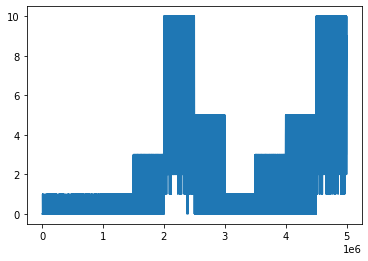

In [14]:
plt.plot(train_val_dataset.samples['open_channels'])

In [15]:
#train_val_dataset.samples.groupby(['observation_batch', 'open_channels']).agg({'open_channels': ['count','max']})

In [16]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        self.layer_dim = layer_dim
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        self.linear = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, dtype=torch.float32).to(device)
        
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, dtype=torch.float32).to(device)
        
        # print(x.float().dtype)
        # print(h0.float().dtype)
        
        # out, hn = self.rnn(x.float(), h0.float().detach())
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        """
        print('out')
        print(out.shape)
        print(out)
        print('hn')
        print(hn.shape)
        print(hn)
        print('cn')
        print(cn.shape)
        print(cn)
        """
        out = self.fc(out[:, -1, :])
        
        # out = self.linear(out)
        
        return out

input_dim = 1
hidden_dim = seq_dim
layer_dim = 3
output_dim = n_categories

model = LSTM(input_dim, hidden_dim, layer_dim, output_dim)
model.to(device)

LSTM(
  (lstm): LSTM(1, 500, num_layers=3, batch_first=True)
  (fc): Linear(in_features=500, out_features=11, bias=True)
  (linear): Linear(in_features=500, out_features=11, bias=True)
)

In [17]:
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 500, num_layers=3, batch_first=True)
  (fc): Linear(in_features=500, out_features=11, bias=True)
  (linear): Linear(in_features=500, out_features=11, bias=True)
)
16
torch.Size([2000, 1])
torch.Size([2000, 500])
torch.Size([2000])
torch.Size([2000])
torch.Size([2000, 500])
torch.Size([2000, 500])
torch.Size([2000])
torch.Size([2000])
torch.Size([2000, 500])
torch.Size([2000, 500])
torch.Size([2000])
torch.Size([2000])
torch.Size([11, 500])
torch.Size([11])
torch.Size([11, 500])
torch.Size([11])


In [18]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [19]:
batch_size = 32
n_iters = 3000
# num_epochs = int(n_iters / (len(train_dataset) / batch_size))
num_epochs = 1

In [20]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [21]:
criterion = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
column_names = ['iteration', 'loss', 'avg_loss', 'avg_val_loss', 'time', 'accuracy']
logging_df = pd.DataFrame(columns=column_names)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=150, factor=0.1, min_lr=1e-8)  # Using ReduceLROnPlateau schedule

start = time.time()

current_loss = 0
all_losses = []

for epoch in range(num_epochs):
    for i, (samples, labels) in enumerate(train_loader):
                
        samples = samples.to(device)
        samples = samples.requires_grad_()
        labels = labels.to(device)
        
        # print(labels.dtype)
        
        optimizer.zero_grad()
        outputs = model(samples)
        
        
        # torch.tensor(asd).round()
        
        loss = criterion(outputs, labels)
        
        loss.backward()

        optimizer.step()
                
        all_losses.append(loss.item())
                
        if i % 500 == 0:
            correct = 0
            total = 0
            inner_iter = 0
            
            val_criterion = nn.CrossEntropyLoss()
            val_all_losses = []
            
            for j, (val_samples, val_labels) in enumerate(val_loader):   
                val_samples = val_samples.to(device)
                val_labels = val_labels.to(device)
                val_outputs = model(val_samples)
                _, predicted = torch.max(outputs.data, 1)
                total += val_labels.size(0)
                val_loss = val_criterion(val_outputs, val_labels)
                val_all_losses.append(val_loss.item())
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == val_labels.cpu()).sum()
                else:
                    correct += (predicted == val_labels).sum()
                if j > min(i, 25):
                    break
            
            scheduler.step(np.mean(val_all_losses))
            accuracy = 100 * correct / total
            elapsed_time = timeSince(start)
            # i_row = [i, loss.item(), accuracy, elapsed_time]
            i_row = [i, loss.item(), np.mean(all_losses), np.mean(val_all_losses), elapsed_time, accuracy]
            #logging_df.loc[i] = i_row
            #logging_df.to_csv(dir_path + 'logs/iterations_metrics.csv')
            if i % 5000 == 0:
                torch.save(model.state_dict(), 'model_' + str(i) + '.pt')
                        
            print('Iteration: {}. Loss: {}. Rolling Loss Avg: {}. Rolling Val Loss Avg: {}. Elapsed Time: {}. accuracy: {}'
                  .format(i, loss.item(), np.mean(all_losses), np.mean(val_all_losses), elapsed_time, accuracy))

/opt/conda/conda-bld/pytorch_1587428398394/work/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


Iteration: 0. Loss: 2.3929107189178467. Rolling Loss Avg: 2.3929107189178467. Rolling Val Loss Avg: 2.3930550813674927. Elapsed Time: 0m 1s. accuracy: 25
Iteration: 500. Loss: 2.179532766342163. Rolling Loss Avg: 2.2597529833426258. Rolling Val Loss Avg: 2.1666088545763933. Elapsed Time: 1m 40s. accuracy: 23
Iteration: 1000. Loss: 2.1046433448791504. Rolling Loss Avg: 2.192660999583912. Rolling Val Loss Avg: 2.0897248321109347. Elapsed Time: 3m 19s. accuracy: 24
Iteration: 1500. Loss: 2.11738920211792. Rolling Loss Avg: 2.1461133933083207. Rolling Val Loss Avg: 1.9881485965516832. Elapsed Time: 4m 58s. accuracy: 23
Iteration: 2000. Loss: 1.4975169897079468. Rolling Loss Avg: 2.0228564907824143. Rolling Val Loss Avg: 1.4170774707087763. Elapsed Time: 6m 36s. accuracy: 16
Iteration: 2500. Loss: 1.404524564743042. Rolling Loss Avg: 1.8966603375396363. Rolling Val Loss Avg: 1.37523822872727. Elapsed Time: 8m 15s. accuracy: 14
Iteration: 3000. Loss: 1.343395709991455. Rolling Loss Avg: 1.78

In [22]:
torch.save(model.state_dict(), 'model_may_25.pt')

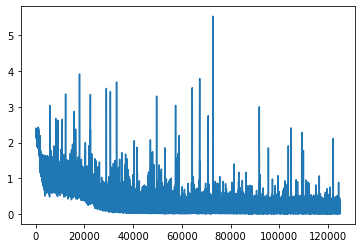

In [23]:
plt.figure()
plt.plot(all_losses)

In [24]:
model.to(device)

LSTM(
  (lstm): LSTM(1, 500, num_layers=3, batch_first=True)
  (fc): Linear(in_features=500, out_features=11, bias=True)
  (linear): Linear(in_features=500, out_features=11, bias=True)
)

In [25]:
test_dataset = IonDataset("/kaggle/input/no-drift-data/kaggle_data/test_no_drift.csv", seq_dim, for_training=False, train_avg=train_val_dataset.avg, train_std=train_val_dataset.std)

In [26]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [27]:
test_p = np.zeros(len(test_dataset))

In [28]:
submission = pd.read_csv("/kaggle/input/no-drift-data/kaggle_data/sample_submission.csv", dtype={'time': str})

In [29]:
model.eval()
start = time.time()

In [30]:
with torch.no_grad():
    for i, (samples) in enumerate(test_loader):
        samples = samples.to(device)
        outputs = model(samples).detach()
        pred = F.softmax(outputs, 1).detach().cpu().numpy().argmax(axis=-1)
        test_p[i * batch_size: (i+1) * batch_size] = pred
        if i % 1000 == 0:
            elapsed_time = timeSince(start)
            print('Iteration: {}. Elapsed Time: {}'
                  .format(i, elapsed_time))
            if i % 10000 == 0:
                submission.open_channels = np.array(test_p, np.int)
                submission.to_csv('submission_may_25_' + str(i) + '.csv')

Iteration: 0. Elapsed Time: 0m 0s
Iteration: 1000. Elapsed Time: 1m 45s
Iteration: 2000. Elapsed Time: 3m 24s
Iteration: 3000. Elapsed Time: 5m 2s
Iteration: 4000. Elapsed Time: 6m 40s
Iteration: 5000. Elapsed Time: 8m 18s
Iteration: 6000. Elapsed Time: 9m 56s
Iteration: 7000. Elapsed Time: 11m 35s
Iteration: 8000. Elapsed Time: 13m 13s
Iteration: 9000. Elapsed Time: 14m 51s
Iteration: 10000. Elapsed Time: 16m 29s
Iteration: 11000. Elapsed Time: 18m 12s
Iteration: 12000. Elapsed Time: 19m 50s
Iteration: 13000. Elapsed Time: 21m 28s
Iteration: 14000. Elapsed Time: 23m 5s
Iteration: 15000. Elapsed Time: 24m 43s
Iteration: 16000. Elapsed Time: 26m 20s
Iteration: 17000. Elapsed Time: 27m 57s
Iteration: 18000. Elapsed Time: 29m 35s
Iteration: 19000. Elapsed Time: 31m 12s
Iteration: 20000. Elapsed Time: 32m 50s
Iteration: 21000. Elapsed Time: 34m 32s
Iteration: 22000. Elapsed Time: 36m 9s
Iteration: 23000. Elapsed Time: 37m 46s
Iteration: 24000. Elapsed Time: 39m 23s
Iteration: 25000. Elapse

In [31]:
submission.open_channels = np.array(test_p, np.int)

In [32]:
submission.to_csv('submission_may_25.csv', index=False)

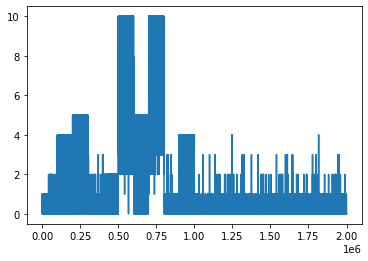

In [33]:
plt.plot(submission['open_channels'])